In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# plt.savefig("foo.png", dpi=300)
import json
from vad_statistics import Statistics
import re
plt.rc('figure', **{'dpi': 200}) 


In [2]:
# find models

model_foldernames = {
    'penn' : {
        'vad' : "20190421 06-00-56 penn vad",
        'seq2seq' : "20190421 05-31-15 penn seq2seq",
        'bowman' : "20190421 08-06-30 penn bowman"
    },
    'amazon' : {
        'vad' : "20190421 04-26-44 amazon vad",
        'seq2seq' : "20190421 04-10-57 amazon seq2seq",
        'bowman' : "20190421 07-32-39 amazon bowman"
    },
    'subtitles' : {
        'vad' : "20190421 02-24-01 subtitles vad",
        'seq2seq' : "20190421 02-24-10 subtitles seq2seq",
        'bowman' : "20190421 07-54-47 subtitles bowman"
    }
}
parentFolder = "models"
lossFolders  = "results"
saveDir = "../Documents/report/results"

In [3]:
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [4]:
def loadResults(model_folder):
    """
    Loads csvs of all epochs from a given model_folder name.
    Returns a concatenation of results.
    """
    # setup filepath
    folder = os.path.join(parentFolder, model_folder, lossFolders)
    files = os.listdir(folder)

    # retrieve .csv files.
    if len(files) < 1: return

    # retrieve only csvs
    files = [i for i in files if (i[-4:].lower() == ".csv")]

    parts = re.match(r"([a-z]+_)([0-9]+)([a-z]+.csv)", files[-1], re.I).groups()

    # sort by epochs (increasing order)
    numbs = sorted([int(re.findall('\d+', i )[0]) for i in files])

    results = []
    for number in numbs:
        # create filename
        file = parts[0] + str(number) + parts[2]
        filepath = os.path.join(folder, file)

        ents = np.loadtxt(filepath, delimiter=", ")
        
        results.append(ents)
    return results

In [5]:
# load results
resultsData = {}
for dataset in model_foldernames.keys():
    for model in model_foldernames[dataset]:
        key = (dataset, model)
        resultsData[key] = {}
        folderpath = os.path.join(parentFolder, model_foldernames[dataset][model])
        losses = loadResults(model_foldernames[dataset][model])
        resultsData[key]['stats'] = losses
        # load bleu rouge
        try:
            with open(os.path.join(folderpath, "bleu_rouge.json"), "r") as f:
                resultsData[key]['bleu_rouge'] = json.load(f)
        except:
            pass

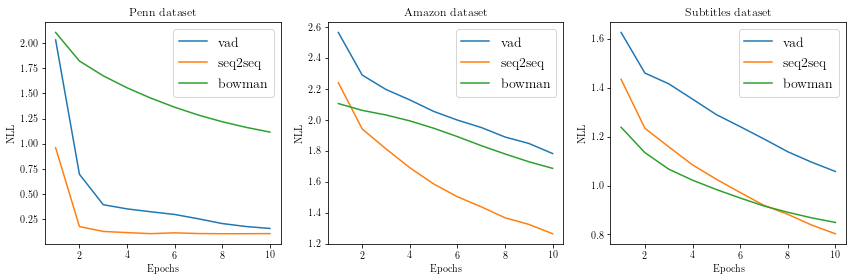

In [6]:
def chartLoss(resultsData):
    
    dataset_keys = {}
    for key in resultsData:
        
        if key[0] not in dataset_keys:
            dataset_keys[key[0]] = {}
            
        epoch_losses = resultsData[key]['stats']
        # cols: loss, KL, BOW
        meanLosses = []
        for epoch in epoch_losses:
            meanLosses.append(np.mean(epoch, axis=0))
        dataset_keys[key[0]][key[1]] = meanLosses
    
    # plot NLL losses
    fig, axes = plt.subplots(1,len(dataset_keys))
    fig.set_figheight(4)
    fig.set_figwidth(12)
    count = -1
    for dataset in dataset_keys:
        count += 1
        for model in dataset_keys[dataset]:
            epoch_size = len(dataset_keys[dataset][model])
            x = [i for i in range(1,epoch_size+1)]
            y = [result[0] for result in dataset_keys[dataset][model]]
            axes[count].plot(x,y,label=model)
        axes[count].set_title(dataset.capitalize()+ " dataset")
        axes[count].set_xlabel("Epochs")
        axes[count].set_ylabel("NLL")
        axes[count].legend()
    fig.tight_layout()
    fig.show()
    filepath = os.path.join(saveDir,"nll.pdf")
    plt.savefig(filepath, bbox_inches='tight')
        
chartLoss(resultsData)

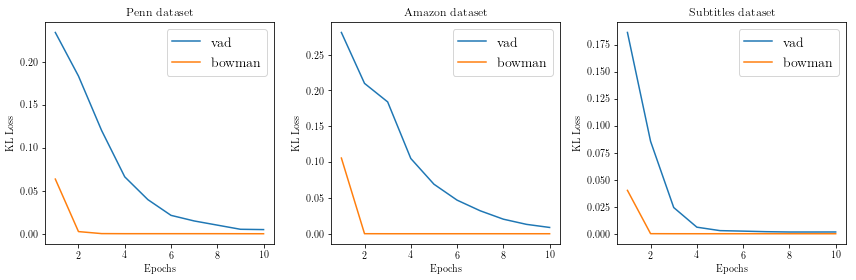

In [7]:
def getKLLoss(resultsData):
    
    dataset_keys = {}
    for key in resultsData:
        if key[-1] == "seq2seq":
            continue
 
        if key[0] not in dataset_keys:
            dataset_keys[key[0]] = {}

        epoch_losses = resultsData[key]['stats']
        # cols: loss, KL, BOW
        KLLosses = []
        for epoch in epoch_losses:

            kl = epoch[:,1]
            KLLosses.append(np.mean(kl))
        dataset_keys[key[0]][key[1]] = KLLosses
        
    fig, axes = plt.subplots(1,len(dataset_keys))
    fig.set_figheight(4)
    fig.set_figwidth(12)
    count = -1
    for dataset in dataset_keys:
        count += 1
        for model in dataset_keys[dataset]:
            epoch_size = len(dataset_keys[dataset][model])
            x = [i for i in range(1,epoch_size+1)]
            y = dataset_keys[dataset][model]
            axes[count].plot(x,y,label=model)
        axes[count].set_title(dataset.capitalize()+ " dataset")
        axes[count].set_xlabel("Epochs")
        axes[count].set_ylabel("KL Loss")
        axes[count].legend()
    fig.tight_layout()
    fig.show()
    filepath = os.path.join(saveDir,"kl_loss.pdf")
    plt.savefig(filepath, bbox_inches='tight')
        
getKLLoss(resultsData)

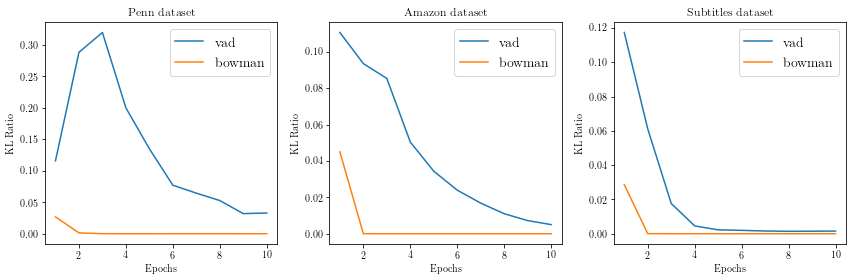

In [8]:
def getKLRatio(resultsData):
    
    dataset_keys = {}
    for key in resultsData:
        if key[-1] == "seq2seq":
            continue
 
        if key[0] not in dataset_keys:
            dataset_keys[key[0]] = {}

        epoch_losses = resultsData[key]['stats']
        # cols: loss, KL, BOW
        meanKL = []
        for epoch in epoch_losses:

            kl = epoch[:,1]
            nll = epoch[:,0]
            ratio = kl/nll
            meanKL.append(np.mean(ratio))
        dataset_keys[key[0]][key[1]] = meanKL
        
    fig, axes = plt.subplots(1,len(dataset_keys))
    fig.set_figheight(4)
    fig.set_figwidth(12)
    count = -1
    for dataset in dataset_keys:
        count += 1
        for model in dataset_keys[dataset]:
            epoch_size = len(dataset_keys[dataset][model])
            x = [i for i in range(1,epoch_size+1)]
            y = dataset_keys[dataset][model]
            axes[count].plot(x,y,label=model)
        axes[count].set_title(dataset.capitalize()+ " dataset")
        axes[count].set_xlabel("Epochs")
        axes[count].set_ylabel("KL Ratio")
        axes[count].legend()
    fig.tight_layout()
    fig.show()
    filepath = os.path.join(saveDir,"kl_ratio.pdf")
    plt.savefig(filepath, bbox_inches='tight')
        
getKLRatio(resultsData)

In [9]:
# need to do bleu/rouge
def chartBLEUROUGE(resultsData, score="bleu1"):
    # get keys
    
    dataset_keys = {}
    for key in resultsData:
        k = resultsData[key]['bleu_rouge']
        width = len(k)
        x = [i for i in range(1,width+1)]
        y = [w[score] for w in k]
        if key[0] not in dataset_keys:
            dataset_keys[key[0]] = {}
        
        dataset_keys[key[0]][key[1]]= {
            'x' : x,
            'y' : y
        }
        
    fig, axes = plt.subplots(1,len(dataset_keys))
    fig.set_figheight(4)
    fig.set_figwidth(12)
    count = -1
        
    for dataset in dataset_keys:
        count += 1
        for model in dataset_keys[dataset]:
            epoch_size = len(dataset_keys[dataset][model])
            x = dataset_keys[dataset][model]['x']
            y = dataset_keys[dataset][model]['y']
            axes[count].plot(x,y,label=model)
        axes[count].set_title(dataset.capitalize()+ " dataset")
        axes[count].set_xlabel("Epochs")
        axes[count].set_ylabel(score.replace("_", " ").upper())
        axes[count].legend()
    fig.tight_layout()
    fig.show()
    filepath = os.path.join(saveDir,score+".pdf")
    plt.savefig(filepath, bbox_inches='tight')

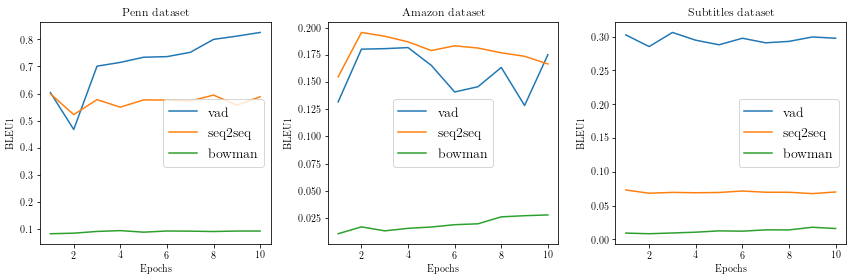

In [10]:
chartBLEUROUGE(resultsData, score="bleu1")

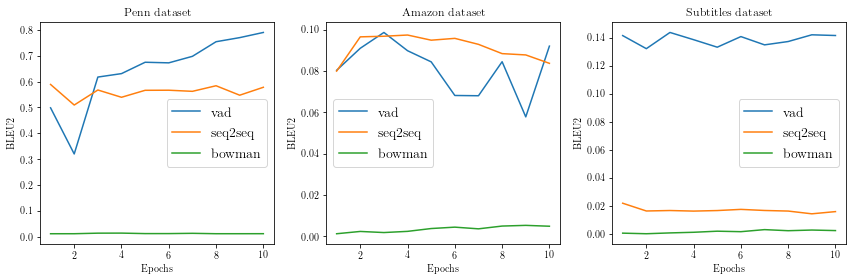

In [11]:
chartBLEUROUGE(resultsData, score="bleu2")

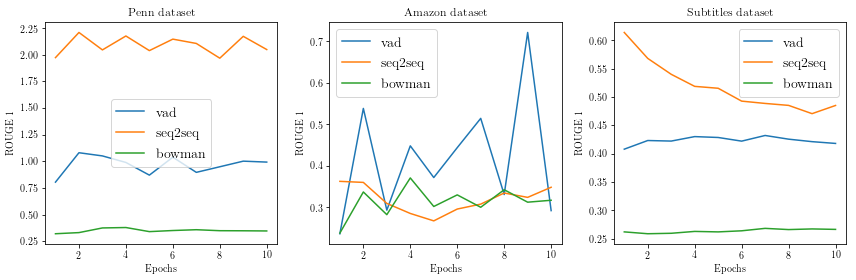

In [12]:
chartBLEUROUGE(resultsData, score="rouge_1")

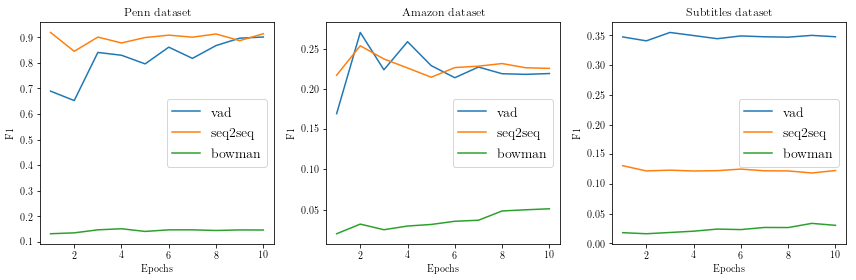

In [13]:
chartBLEUROUGE(resultsData, score="f1")

we need to chart Loss, KL Ratio, samples, variance of results, bleu/rouge